## 1. Preparación de nuestro conjunto de datos
En los últimos años, los servicios de streaming con enormes catálogos se han convertido en el principal medio a través del cual la mayoría de la gente escucha su música favorita. Pero, al mismo tiempo, la gran cantidad de música que ofrecen puede abrumar a los usuarios a la hora de buscar novedades que se ajusten a sus gustos.

Por eso, los servicios de streaming han buscado formas de categorizar la música para ofrecer recomendaciones personalizadas. Uno de los métodos consiste en analizar directamente la información de audio en bruto de una canción determinada, puntuándola según una serie de parámetros. Hoy examinaremos los datos recopilados por un grupo de investigación conocido como The Echo Nest. Nuestro objetivo es examinar este conjunto de datos y clasificar las canciones como «Hip-Hop» o «Rock», sin escuchar ni una sola. Para ello, aprenderemos a limpiar nuestros datos, a visualizarlos de forma exploratoria y a utilizar la reducción de características con el objetivo de introducir nuestros datos en algunos algoritmos sencillos de aprendizaje automático, como los árboles de decisión y la regresión logística.

Para empezar, vamos a cargar los metadatos de nuestras canciones junto con las métricas de canciones recopiladas por The Echo Nest. Una canción es algo más que su título, artista y número de escuchas. Tenemos otro conjunto de datos que contiene características musicales de cada canción, como la bailabilidad y la acústica, en una escala de -1 a 1. Estos datos se encuentran en dos archivos diferentes, con formatos distintos: CSV y JSON. Mientras que CSV es un formato de archivo popular para denotar datos tabulares, JSON es otro formato de archivo común en el que las bases de datos suelen devolver los resultados de una consulta determinada.

Vamos a empezar por crear dos pandas DataFrames de estos archivos que podemos combinar para tener características y etiquetas (a menudo también referido como X e y) para la clasificación más adelante.



In [ ]:
import pandas as pd

#Lectura de metadatos de pistas con etiquetas de género
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# "Leer las métricas de la pista con las características"
echonest_metrics = pd.read_json('datasets/echonest-metrics.json',precise_float = True)

#Fusionar las columnas relevantes de tracks y echonest_metrics
echo_tracks = echonest_metrics.merge(tracks[['genre_top','track_id']],on = 'track_id')

# Inspeccionamos el dataset resultante
echo_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


In [ ]:
echo_tracks.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


## 2. Relaciones por pares entre variables continuas
<p>Normalmente queremos evitar el uso de variables que tengan fuertes correlaciones entre sí -evitando así la redundancia de características- por varias razones:</p>
<ul>
<li>Para mantener el modelo simple y mejorar la interpretabilidad (Con muchas características, corremos el riesgo de sobreajustar).</li>
<li>Cuando nuestros conjuntos de datos son muy grandes, utilizar menos características puede acelerar drásticamente el tiempo de cálculo.</li>
</ul>
<p>Para hacernos una idea de si existen características fuertemente correlacionadas en nuestros datos, utilizaremos funciones integradas en el paquete <code>pandas</code>.</p>

In [ ]:
# Creación de la matriz de correlación
corr_metrics = echonest_metrics.corr()
corr_metrics.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.279829,0.102056,0.121991,-0.283206,-0.004059,-0.075077,0.004313,0.020201
acousticness,-0.279829,1.000000,-0.189599,-0.477273,0.110033,0.041319,0.038785,-0.110701,-0.085436
danceability,0.102056,-0.189599,1.000000,0.045345,-0.118033,-0.143339,0.171311,-0.094352,0.428515
energy,0.121991,-0.477273,0.045345,1.000000,-0.002412,0.045752,-0.008645,0.227324,0.219384
instrumentalness,-0.283206,0.110033,-0.118033,-0.002412,1.000000,-0.058593,-0.216689,0.023003,-0.145200
liveness,-0.004059,0.041319,-0.143339,0.045752,-0.058593,1.000000,0.073104,-0.007566,-0.017886
speechiness,-0.075077,0.038785,0.171311,-0.008645,-0.216689,0.073104,1.000000,0.032188,0.094794
tempo,0.004313,-0.110701,-0.094352,0.227324,0.023003,-0.007566,0.032188,1.000000,0.129911
valence,0.020201,-0.085436,0.428515,0.219384,-0.145200,-0.017886,0.094794,0.129911,1.000000


## 3. División de datos
<p>Como ya hemos dicho, puede ser muy útil simplificar los modelos y utilizar el menor número de características posible para obtener el mejor resultado. Como no hemos encontrado correlaciones especialmente fuertes entre nuestras características, podemos dividir los datos en una matriz que contenga nuestras características y otra que contenga las etiquetas, es decir, el género de la canción. </p>
<p>Una vez que hayamos dividido los datos en estas matrices, realizaremos algunos pasos de preprocesamiento para optimizar el desarrollo de nuestro modelo.</p>

In [ ]:
# Importamos la función train_test_split
from sklearn.model_selection import train_test_split

# Creación de "features"
features = echo_tracks.drop(["genre_top","track_id"],axis=1).values

# Creación de "labels"
labels = echo_tracks["genre_top"].values

# Dividimos nuestros datos
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 10)

## 4. Normalización de los datos de características
<p>Como se mencionó anteriormente, puede ser particularmente útil simplificar nuestros modelos y utilizar la menor cantidad de características necesarias para lograr el mejor resultado. Dado que no encontramos ninguna correlación fuerte en particular entre nuestras características, podemos utilizar en su lugar un enfoque común para reducir la cantidad de características llamado <strong>análisis de componentes principales (PCA)</strong>. </p>
<p>Es posible que la varianza entre géneros pueda explicarse por unas pocas características del conjunto de datos. El ACP rota los datos a lo largo del eje de mayor varianza, lo que nos permite determinar la contribución relativa de cada característica de nuestros datos a la varianza entre clases.</p>
<p>Sin embargo, dado que el PCA utiliza la varianza absoluta de una característica para rotar los datos, una característica con un rango más amplio de valores dominará y sesgará el algoritmo en relación con las otras características. Para evitar esto, primero debemos normalizar nuestras características de entrenamiento y prueba. Hay algunos métodos para hacer esto, pero una forma común es a través de la <em>estandarización</em>, de modo que todas las características tengan una media = 0 y una desviación estándar = 1 (el resultado es una puntuación z). </p>

In [ ]:
# Importamos StandardScaler
from sklearn.preprocessing import StandardScaler

#Escalar las características y establecer los valores en una nueva variable
scaler = StandardScaler()

# Escala train_features y test_features
scaled_train_features = scaler.fit_transform(train_features)
scaled_test_features = scaler.transform(test_features)

## 5. Análisis de componentes principales en nuestros datos escalados
<p>Ahora que hemos preprocesado nuestros datos, estamos listos para utilizar el PCA para determinar en qué medida podemos reducir la dimensionalidad de nuestros datos.  Podemos utilizar scree-plots y cumulative explained ratio plots para averiguar el número de componentes que debemos utilizar en análisis posteriores.</p>
<p>Los gráficos de escala muestran el número de componentes frente a la varianza explicada por cada componente, ordenados por orden descendente de varianza. Los gráficos de escala nos ayudan a hacernos una mejor idea de qué componentes explican una cantidad suficiente de varianza en nuestros datos. Cuando se utilizan los gráficos scree, se suele utilizar un «codo» (una caída pronunciada de un punto de datos al siguiente) en el gráfico para decidir un punto de corte adecuado.</p>

Text(0.5, 0, 'Principal Component #')

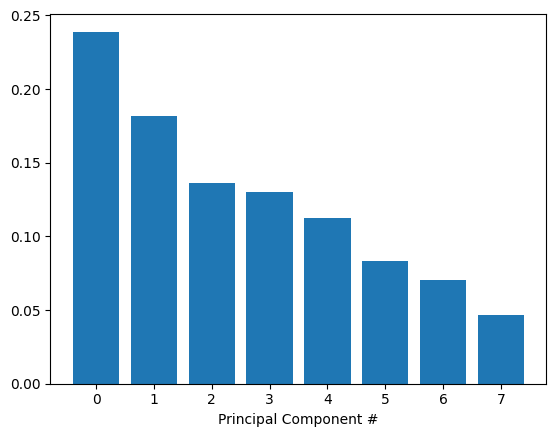

In [ ]:
# Esto es sólo para hacer que los plots aparezcan en el notebook
%matplotlib inline

# Importa nuestro módulo de trazado y la clase PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Obtenga nuestros ratios de varianza explicada a partir de PCA utilizando todas las características
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# Trazamos la varianza explicada mediante un diagrama de barras
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

## 6. Visualización adicional de PCA
<p>Desgraciadamente, no parece haber un codo claro en este gráfico de dispersión, lo que significa que no es sencillo hallar el número de dimensiones intrínsecas utilizando este método. </p>
<p>Pero no todo está perdido. En su lugar, también podemos observar el gráfico de la varianza explicada acumulada para determinar cuántas características son necesarias para explicar, por ejemplo, alrededor del 85% de la varianza (los límites son algo arbitrarios en este caso, y normalmente se deciden mediante «reglas empíricas»). Una vez determinado el número apropiado de componentes, podemos realizar PCA con ese número de componentes, reduciendo idealmente la dimensionalidad de nuestros datos.</p>

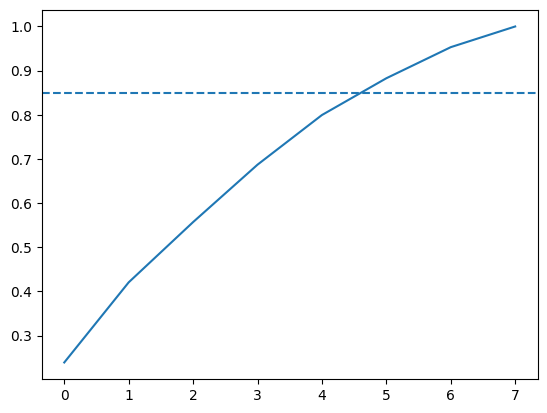

In [ ]:
# Importamos numpy
import numpy as np

# Calcular la varianza explicada acumulada
cum_exp_variance = np.cumsum(exp_variance)

#Represente gráficamente la varianza explicada acumulada y trace una línea discontinua en 0,85.
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')

## 7. Proyección sobre nuestras características
<p>El gráfico muestra que 6 características (recuerde que la indexación empieza en 0) pueden explicar el 85% de la varianza. </p>
<p>Por lo tanto, podemos utilizar 6 componentes para realizar el PCA y reducir la dimensionalidad de nuestras características de entrenamiento y prueba.</p>

In [ ]:
# Realice el PCA con el número de componentes elegido y proyecte los datos sobre los componentes
pca = PCA(n_components = 6, random_state = 10)

# Ajuste y transformación de las características de entrenamiento escaladas mediante pca
train_pca = pca.fit_transform(scaled_train_features)

#Ajuste y transformación de las características de prueba escaladas mediante pca
test_pca = pca.transform(scaled_test_features)

## 8. Entrenar un árbol de decisión para clasificar el género
<p>Ahora podemos utilizar la proyección PCA de menor dimensión de los datos para clasificar las canciones en géneros. </p>
<p>En este caso, utilizaremos un algoritmo sencillo conocido como árbol de decisión. Los árboles de decisión son clasificadores basados en reglas que toman características y siguen una «estructura de árbol» de decisiones binarias para, en última instancia, clasificar un punto de datos en una de dos o más categorías. Además de ser fáciles de utilizar e interpretar, los árboles de decisión nos permiten visualizar el «diagrama de flujo lógico» que el modelo genera a partir de los datos de entrenamiento.</p>
<p>He aquí un ejemplo de árbol de decisión que demuestra el proceso por el que una imagen de entrada (en este caso, de una forma) podría clasificarse en función del número de lados que tiene y de si está girada.</p>
<p><img src="https://assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [ ]:
# Importamos Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Creamos nuestra decision tree
tree = DecisionTreeClassifier(random_state=10)

# Entrenamos nuestra decision tree
tree.fit(train_pca, train_labels)

# Predecimos las etiquetas de los datos de prueba
pred_labels_tree = tree.predict(test_pca)

## 9. Compare nuestro árbol de decisión con una regresión logística
<p>Aunque el rendimiento de nuestro árbol es decente, es una mala idea asumir inmediatamente que es la herramienta perfecta para este trabajo: ¡siempre existe la posibilidad de que haya otros modelos con un rendimiento aún mejor! Siempre merece la pena probar al menos otros algoritmos y encontrar el que mejor se adapte a nuestros datos.</p>
<p>A veces lo más sencillo es lo mejor, así que empezaremos aplicando la <strong>regresión logística</strong>. La regresión logística hace uso de lo que se denomina función logística para calcular las probabilidades de que un punto de datos determinado pertenezca a una clase determinada. Una vez que tenemos ambos modelos, podemos compararlos en algunas métricas de rendimiento, como la tasa de falsos positivos y falsos negativos (o cuántos puntos se clasifican incorrectamente). </p>

In [ ]:
# Importamos LogisticRegression
from sklearn.linear_model import LogisticRegression

# Entrenar nuestra regresión logística y predecir etiquetas para el conjunto de pruebas
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca,train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Crear el informe de clasificación para ambos modelos
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.63      0.62      0.62       235
        Rock       0.91      0.91      0.91       966

    accuracy                           0.85      1201
   macro avg       0.77      0.77      0.77      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



## 10. Equilibrar nuestros datos para un mayor rendimiento
<p>Nuestros dos modelos obtienen resultados similares, con una precisión media del 87% cada uno. Sin embargo, si observamos nuestro informe de clasificación, podemos ver que las canciones de rock se clasifican bastante bien, pero las de hip-hop se clasifican erróneamente como canciones de rock de forma desproporcionada. </p>
<p>¿Por qué? Sólo con mirar el número de puntos de datos que tenemos para cada clase, vemos que tenemos muchos más puntos de datos para la clasificación de rock que para la de hip-hop, lo que podría sesgar la capacidad de nuestro modelo para distinguir entre clases. Esto también nos indica que la mayor parte de la precisión de nuestro modelo se debe a su capacidad para clasificar únicamente canciones de rock, lo que no es lo ideal.</p>
<p>Para tenerlo en cuenta, podemos ponderar el valor de una clasificación correcta en cada clase de forma inversa al número de puntos de datos de cada clase. Dado que una clasificación correcta de «Rock» no es más importante que una clasificación correcta de «Hip-Hop» (y viceversa), al ponderar nuestras clases sólo tenemos que tener en cuenta las diferencias en el tamaño de la muestra de nuestros puntos de datos, y no la importancia relativa de cada clase. </p>

In [ ]:
#Subconjunto sólo de las pistas de hip-hop, y luego sólo las pistas de rock
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

#Muestrear las canciones de rock para que sean el mismo número que hay de hip-hop
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

#Concatenar los dataframes rock_only y hop_only
rock_hop_bal = pd.concat([rock_only, hop_only])


#Las características, las etiquetas y la proyección pca se crean para el marco de datos equilibrado
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1)
labels = rock_hop_bal['genre_top']

#Redefinir el conjunto de entrenamiento y prueba con la proyección_pca a partir de los datos equilibrados.
train_features, test_features, train_labels, test_labels = train_test_split(features,labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))

## 11. ¿El equilibrio de nuestro conjunto de datos mejora el sesgo del modelo?
<p>Ahora hemos equilibrado nuestro conjunto de datos, pero al hacerlo, hemos eliminado muchos puntos de datos que podrían haber sido cruciales para entrenar nuestros modelos. Comprobemos si el equilibrio de los datos mejora el sesgo del modelo hacia la clasificación «Rock», manteniendo al mismo tiempo el rendimiento general de la clasificación. </p>
<p>Tenga en cuenta que ya hemos reducido el tamaño de nuestro conjunto de datos y que seguiremos adelante sin aplicar ninguna reducción de la dimensionalidad. En la práctica, consideraremos la reducción de la dimensionalidad de forma más rigurosa cuando tratemos con conjuntos de datos enormemente grandes y cuando los tiempos de cálculo sean prohibitivos.</p>

In [ ]:
# Entrenar nuestro árbol de decisión en los datos equilibrados
tree = DecisionTreeClassifier(random_state = 10)
tree.fit(train_pca,train_labels)
pred_labels_tree = tree.predict(test_pca)

# Entrenar nuestra regresión logística en los datos equilibrados
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_pca,train_labels)
pred_labels_logit = logreg.predict(test_pca)

# Comparamos los modelos
print("Decision Tree: \n", classification_report(test_labels,pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels,pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.82      0.77      0.79       230
        Rock       0.78      0.82      0.80       225

    accuracy                           0.80       455
   macro avg       0.80      0.80      0.80       455
weighted avg       0.80      0.80      0.80       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.81      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.83      0.82      0.82       455



## 12. Validación cruzada para evaluar nuestros modelos
<p>El equilibrio de los datos ha eliminado el sesgo hacia la clase más prevalente. Para hacernos una idea de lo bien que funcionan nuestros modelos, podemos aplicar lo que se denomina validación cruzada (CV). Este paso nos permite comparar modelos de forma más rigurosa.</p>
<p>Antes de poder realizar la validación cruzada, tendremos que crear canalizaciones para escalar nuestros datos, realizar PCA e instanciar nuestro modelo de elección: DecisionTreeClassifier o LogisticRegression.</p>
<p>Dado que la forma en que se dividen los datos en conjuntos de entrenamiento y prueba puede afectar al rendimiento del modelo, la CV intenta dividir los datos de varias formas y probar el modelo en cada una de las divisiones. Aunque existen muchos métodos diferentes de CV, todos con sus propias ventajas y desventajas, aquí utilizaremos el conocido como CV K-fold. K-fold divide primero los datos en K subconjuntos diferentes de igual tamaño. A continuación, utiliza de forma iterativa cada subconjunto como conjunto de prueba mientras utiliza el resto de los datos como conjuntos de entrenamiento. Por último, podemos agregar los resultados de cada pliegue para obtener una puntuación final del rendimiento del modelo.</p>

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)),
                        ("logreg", LogisticRegression(random_state=10))])

# Configuramos nuestra validación cruzada K-fold
kf = KFold(10)

# Entrena nuestros modelos usando KFold cv
tree_score = cross_val_score(tree_pipe,train_features,train_labels,cv=kf)
logit_score = cross_val_score(logreg_pipe,train_features,train_labels,cv=kf)

# Imprime la media de cada matriz de puntuaciones
print("Decision Tree:", tree_score.mean(), "Logistic Regression:", logit_score.mean())

Decision Tree: 0.7677221983683984 Logistic Regression: 0.8249892657793044
